# Personalized Medicine - Exploratory Data Analysis

## Running the notebook as powerpoint
```
jupyter nbconvert Final.ipynb --to slides --post serve
```

## Importing data

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from bs4 import BeautifulSoup
import re
%matplotlib inline

In [2]:
var_path = "Data/training_variants"
text_path = "Data/training_text"

d_train = pd.read_csv(var_path)
d_text = pd.read_csv(text_path, sep = "\|\|", skiprows=1, names = ['ID','Text'], engine="python")

## About our Project
- Goal: Automatically classify genetic mutations that contribute to cancer tumor growth (drivers) vs. presence of mutations that don’t affect the tumors (passengers)
- Data: 2 Files
    - Gene Data - Describes gene record
    - Gene Text Data - Background information of the corresponding gene

### Gene Data

In [29]:
d_train.head(10)

,ID,Gene,Variation,Class,GeneCode,VariationCode
0,0,FAM58A,Truncating Mutations,1,85,2629
1,1,CBL,W802*,2,39,2856
2,2,CBL,Q249E,2,39,1897
3,3,CBL,N454D,3,39,1667
4,4,CBL,L399V,4,39,1447
5,5,CBL,V391I,4,39,2723
6,6,CBL,V430M,5,39,2727
7,7,CBL,Deletion,1,39,473
8,8,CBL,Y371H,4,39,2923
9,9,CBL,C384R,4,39,212


### Text Data

In [4]:
d_text.head(10)

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...
5,5,Oncogenic mutations in the monomeric Casitas B...
6,6,Oncogenic mutations in the monomeric Casitas B...
7,7,CBL is a negative regulator of activated recep...
8,8,Abstract Juvenile myelomonocytic leukemia (JM...
9,9,Abstract Juvenile myelomonocytic leukemia (JM...


## Variants file

### Variable Understanding

What are the data types?

In [5]:
d_train.dtypes

ID            int64
Gene         object
Variation    object
Class         int64
dtype: object

- ID - A specific gene of the specimen
- Gene - The specific gene where the mutation took place
- Variation - the nature of the mutation
- Class - Class which we must predict
    - between 1 and 9

How many unique values/categories for each attribute?

In [6]:
d_train.apply(pd.Series.nunique)

ID           3321
Gene          264
Variation    2996
Class           9
dtype: int64

We now know that there are 3321 records in our training set - all of which are unique.
Although we have 264 unique genes and 2996 unique variations.
Lastly there are 9 classes.

Do we have any missing values?

In [7]:
d_train.isnull().sum()

ID           0
Gene         0
Variation    0
Class        0
dtype: int64

We know that there are no null values in the dataset.

### Univariant Analysis

### Class

What if the frequency of each class?

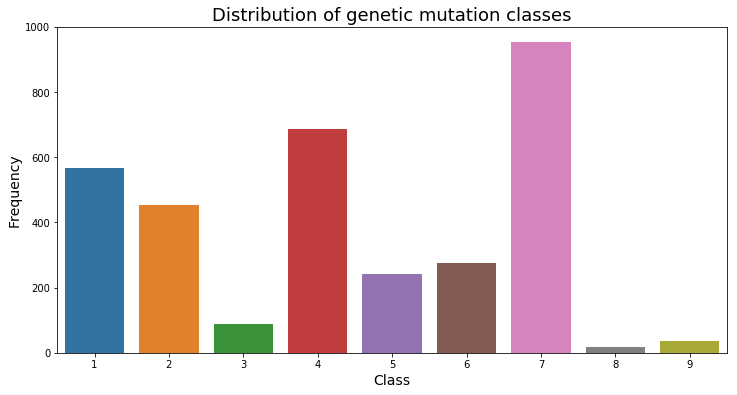

In [8]:
plt.figure(figsize=(12,6))
sns.countplot(x="Class", data=d_train)
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Class', fontsize=14)
plt.title("Distribution of genetic mutation classes", fontsize=18)
plt.show()

- Class 7 is very common, followed by 1, 2, and 4
- Class 3, 8, 9 are not very common

### Gene

How often does each mutation class appear in the dataset?

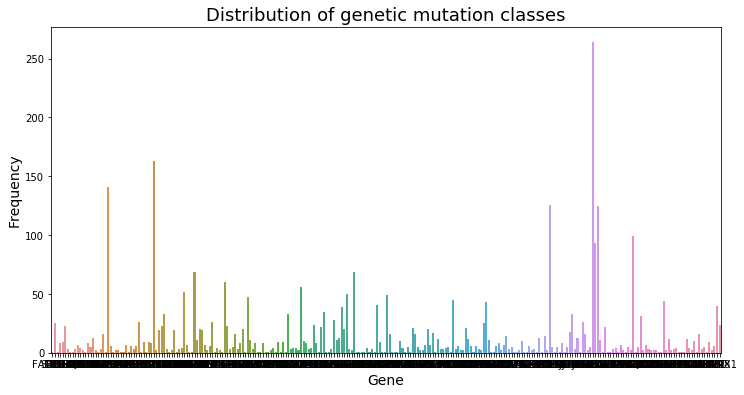

In [9]:
plt.figure(figsize=(12,6))
sns.countplot(x="Gene", data=d_train)
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Gene', fontsize=14)
plt.title("Distribution of genetic mutation classes", fontsize=18)
plt.show()

THat's a lot of mutations! Let's look at the top 10.

In [10]:
# Find top 10 genes
gene_freq = d_train['Gene'].value_counts()
print("Top-10 Gene Occurances\n")
print(gene_freq.head(10))

Top-10 Gene Occurances

BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
KIT        99
BRAF       93
ALK        69
ERBB2      69
PDGFRA     60
Name: Gene, dtype: int64


Gene frequency appears to be left skewed

How many genes appear only a few times?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1964475dd8>]], dtype=object)

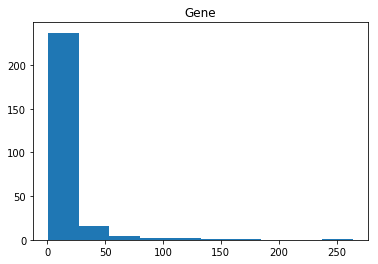

In [11]:
pd.DataFrame(gene_freq).hist(grid='False')

- There are a lot of genes that appear only once, and quite a few appear twice

In [12]:
#Get frequency and standard deviation for genes occuring more than once
filter_genes = gene_freq[gene_freq > 2]
print(stats.kurtosis(filter_genes),stats.skew(filter_genes))

24.253454297558463 4.360256036389982


### Variation

What kind of information can we get from variation?

In [13]:
print("Description of Variation")
print(d_train['Variation'].describe())
print("\nTop Five Variations")
print(d_train['Variation'].value_counts().head(5))

Description of Variation
count                     3321
unique                    2996
top       Truncating Mutations
freq                        93
Name: Variation, dtype: object

Top Five Variations
Truncating Mutations    93
Deletion                74
Amplification           71
Fusions                 34
Overexpression           6
Name: Variation, dtype: int64


- There are a lot of unique variation
- Only the top foud variations appear somewhat often
- Variation may not provide much information

## Bivariant Analysis

In [14]:
# Converting Gene and Variation to categories
d_train['Gene'] = d_train['Gene'].astype('category')
d_train['Variation'] = d_train['Variation'].astype('category')
d_train['Gene'].head().cat.codes
d_train['GeneCode'] = d_train['Gene'].cat.codes
d_train['VariationCode'] = d_train['Variation'].cat.codes
d_train.head()

,ID,Gene,Variation,Class,GeneCode,VariationCode
0,0,FAM58A,Truncating Mutations,1,85,2629
1,1,CBL,W802*,2,39,2856
2,2,CBL,Q249E,2,39,1897
3,3,CBL,N454D,3,39,1667
4,4,CBL,L399V,4,39,1447


Are there any correlation between attributes?

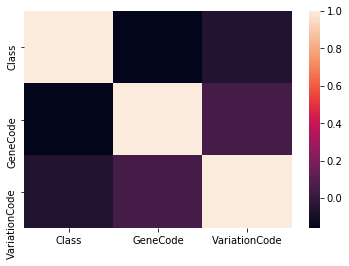

In [15]:
# Calculate correlations
corr = d_train[['Class', 'GeneCode', 'VariationCode']].corr()

# Heatmap
sns.heatmap(corr)
plt.figure(figsize=(10,10))
plt.show()

- There does not appear to be much correlation anywhere
- Would there be a stronger correlation if we only looked at the top 20 genes?

### Gene (top 20) and Variation

Reduced dataset to only contain records of the top 20 most frequent genes

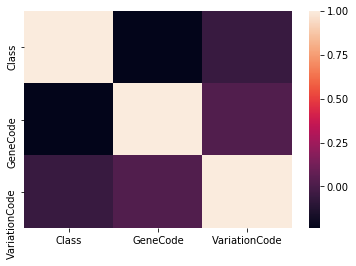

In [16]:
#Correlation using top 20 genes
top_20_genes = d_train[(d_train['Gene'].isin(gene_freq.head(20).index))]

# Calculate correlations
corr = top_20_genes[['Class', 'GeneCode', 'VariationCode']].corr()

# Heatmap
sns.heatmap(corr)
plt.show()

- Still does not appear to have much correlation

### Top 20 Gene Distribution by Class

Are certain genes (top 20) more likely to be classified as a particular class?

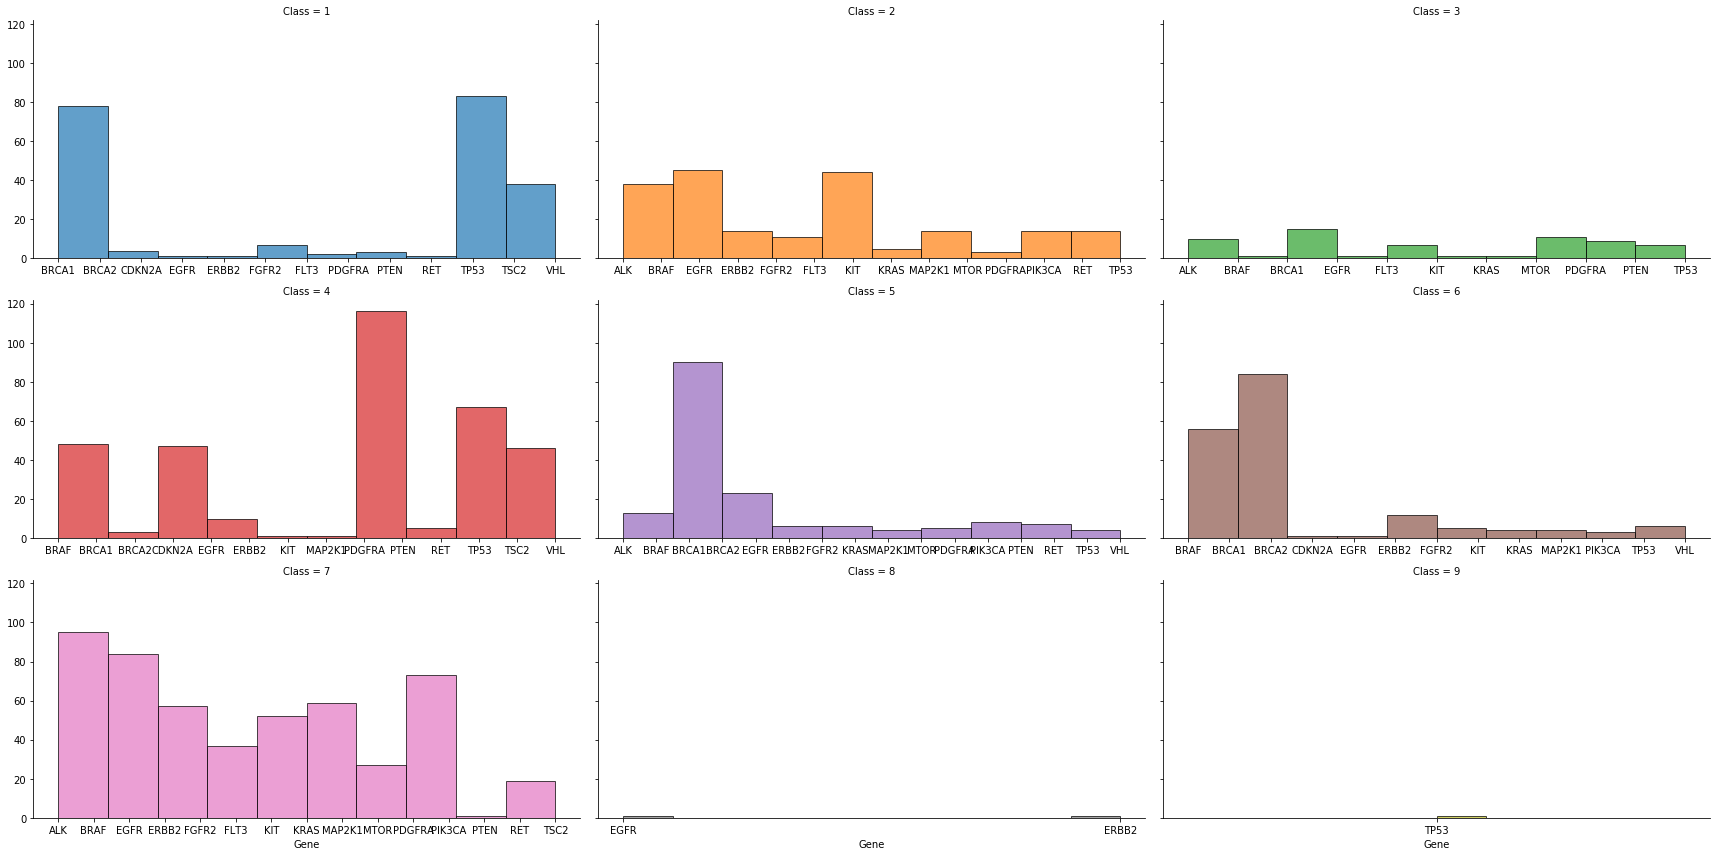

In [17]:
g = sns.FacetGrid(top_20_genes, col="Class", col_wrap=3, size=4, aspect=2, hue="Class", margin_titles=True, sharex=False)
g.map(plt.hist, "Gene", alpha=0.7, edgecolor='#000000');

In [18]:
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(0)
plt.tight_layout()

## Text File (Natural Language Processing)

### Categorize by Class

In [19]:
merged_data = pd.merge(d_train,d_text,on='ID')
merged_data['Class'].value_counts()


7    953
4    686
1    568
2    452
6    275
5    242
3     89
9     37
8     19
Name: Class, dtype: int64

In [20]:
#Get class1 text
class1_text = merged_data[merged_data['Class'] == 1]['Text']
class1_text = pd.DataFrame(class1_text)
class1_text = class1_text.reset_index(drop=True)
#class1_text

In [21]:
def review_to_words( raw_review ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text() 
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))  
clean_review = review_to_words( class1_text["Text"][0] )
#print(clean_review)

In [22]:
# Get the number of reviews based on the dataframe column size
num_reviews = class1_text["Text"].size

print("Cleaning and parsing the training set movie reviews...\n")
clean_train_reviews = []
for i in range( 0, num_reviews ):
    # If the index is evenly divisible by 1000, print a message
    if( (i+1)%1000 == 0 ):
        print("Review %d of %d\n" % ( i+1, num_reviews ))                                                               
    clean_train_reviews.append( review_to_words( class1_text["Text"][i] ))

Cleaning and parsing the training set movie reviews...



In [23]:
print("Creating the bag of words...\n")
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
train_data_features = vectorizer.fit_transform(clean_train_reviews)

# Numpy arrays are easy to work with, so convert the result to an 
# array
train_data_features = train_data_features.toarray()

Creating the bag of words...



In [24]:
print(train_data_features.shape)

(568, 5000)


In [25]:
# Take a look at the words in the vocabulary
vocab = vectorizer.get_feature_names()
#print(vocab)

In [26]:
# Sum up the counts of each vocabulary word
dist = np.sum(train_data_features, axis=0)
#print(train_data_features)
#print(type(vocab))
# For each, print the vocabulary word and the number of times it 
# appears in the training set
#for tag, count in zip(vocab, dist):
#    print(count, tag)

In [27]:
df1 = pd.DataFrame(vocab, columns=['word'])
df2 = pd.DataFrame(dist, columns=['count'])
df2.head(10)
df3 = pd.concat([df1, df2], axis=1)
df3.head(10)
df3.set_index('word')
df3 = df3.sort_values('count', ascending=False)
df3.head()
df4 = df3.set_index('word')['count']
#print(df4)
d = df4.to_dict()
#print(d)

What does the distribution of words for class 1 genes look like?

In [30]:
from wordcloud import WordCloud
cloud = WordCloud(background_color="white")

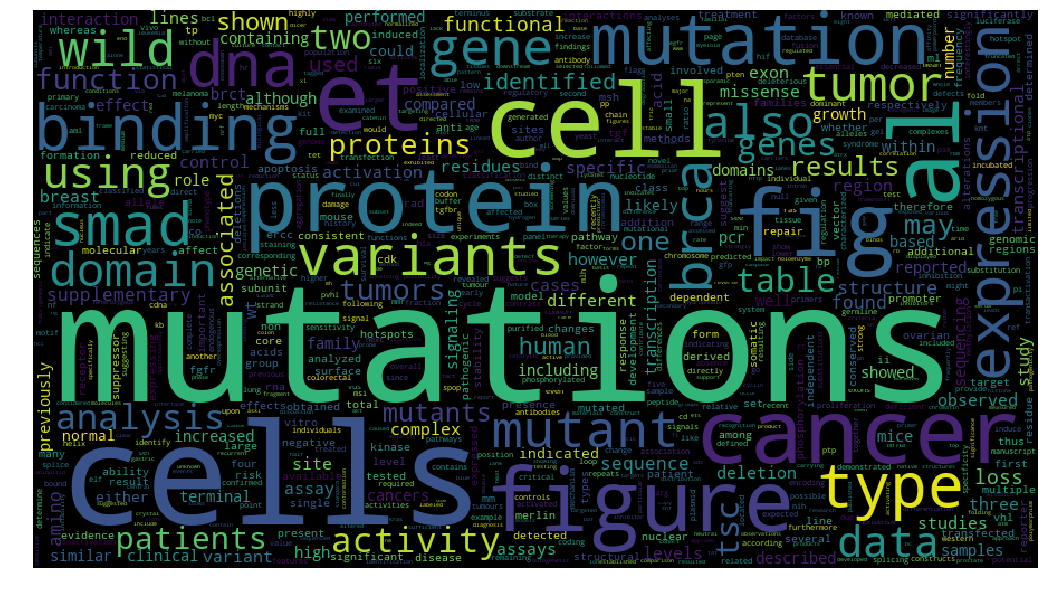

In [34]:
positive_cloud = WordCloud(width=900,height=500, max_words=1628,relative_scaling=1,normalize_plurals=False).generate_from_frequencies(d)
plt.figure(figsize=(18,18))
plt.imshow(positive_cloud)
plt.axis("off")
plt.show()

## Challenges

- Learning to deal with common challenges of text mining
- Using Natural Language processing libraries/toolkits in a Biomedical environment
    - Proposed solution: Biomedical terminology banks are available for the purposes of text mining although operating system restrictions and pay walls must be overcome. 
- Some test data is machine generated therefore text analysis may give unusual results
    - Proposed solution: Parse through machine generated text and differentiate between noise and actual data.

## Timeline

- Data Exploration: January 22, 2018 - February 5, 2018 (Weeks 3-5)
- Data Preparation: February 5, 2018 - March 2, 2018 (Weeks 5-8)
- Modeling: March 2, 2018 - March 20, 2018 (Weeks 8-10)
- Documentation and Poster: March 20, 2018 - April 6, 2018 (Weeks 10-12)